# Image Captioning with YOLO as the encoder -  Final Project
## Look Only Once, attend, and tell (by Farzan Memarian and Amin Anvari)


In this final project we are planning to train a novel image-to-caption model, that can produce descriptions for real world images! The idea is, we are going to use YOLO object detection system as our encoder.


# Import stuff

In [1]:
import sys
sys.path.append("../utils")
sys.path.append("..")

In [2]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
from keras.models import load_model
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
from pdb import set_trace
from keras.preprocessing import sequence
import cv2

from IPython.display import Image

Using TensorFlow backend.


# Download data

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

The above files can also we downloaded form the coco website much faster:
- train images http://images.cocodataset.org/zips/train2014.zip
- valication images http://images.cocodataset.org/zips/val2014.zip
- test images http://images.cocodataset.org/zips/test2014.zip


# Extract image features

We will use pre-trained yoloV2, yolo9000, and InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

In [3]:
# IMG_SIZE = 299
IMG_SIZE = 608
# IMG_SIZE = 544

In [4]:
# # we take the last hidden layer of IncetionV3 as an image embedding
# # comment this if you want to use yolo as the encoder
# def get_cnn_encoder():
#     K.set_learning_phase(0)
#     model = keras.applications.InceptionV3(include_top=False)
#     preprocess_for_model = keras.applications.inception_v3.preprocess_input

#     model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
#     return model, preprocess_for_model

In [5]:
def yolo_preprocess_input(x):
    x /= 255.
    return x

In [6]:
action = 'AveragePooling2D'

# yolo_model_location = '/home/anvaribs/YAD2K/model_data/yolo.h5'
yolo_model_location = '../models/yolo.h5'
# yolo_model_location = '../models/yolo9000.h5'

# we take the last hidden layer of yolo as an image embedding
def get_yolo_encoder():
    K.set_learning_phase(0)
    yolo_model = load_model(yolo_model_location)
    #This needs to be changed
    yolo_preprocess_for_model = yolo_preprocess_input

    if action == 'GlobalAvgPool2D':
        finalOutput = keras.layers.GlobalAvgPool2D()(yolo_model.layers[-2].output)
    if action == 'GlobalAvgPool2D_9000':
        finalOutput = keras.layers.GlobalAvgPool2D()(yolo_model.layers[-2].output)
    if action == 'GlobalAvgPool2D_last':
        finalOutput = keras.layers.GlobalAvgPool2D()(yolo_model.layers[-1].output)
    if action == 'AveragePooling2D':
        finalOutput = keras.layers.AveragePooling2D((5, 5), strides=(5, 5), name='added_pool')(yolo_model.layers[-2].output)
        finalOutput = keras.layers.Flatten()(finalOutput)
    if action == 'AutoEncoder':
        pass
#     yolo_model = keras.engine.training.Model(yolo_model.inputs, keras.layers.GlobalAveragePooling2D()(yolo_model.output))
    yolo_model = keras.engine.training.Model(yolo_model.inputs, finalOutput)

    return yolo_model, yolo_preprocess_for_model

In [7]:
yolo_encoder, yolo_preprocess_for_model = get_yolo_encoder()

/home/farzan15/anaconda3/envs/tf/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


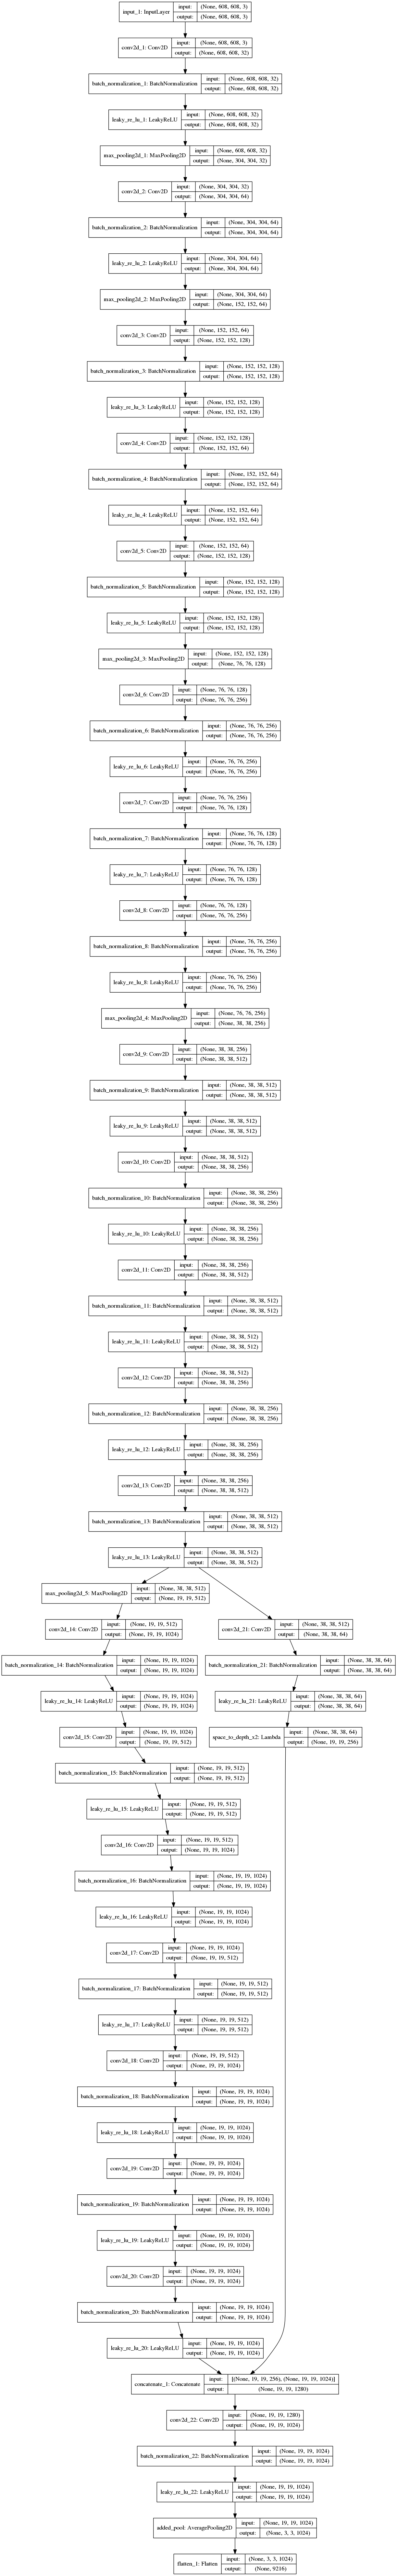

In [8]:
# yolo_encoder.summary()
from keras.utils import plot_model
plot_model(yolo_encoder, to_file='../models/yolo_encoder_{}.png'.format(action), show_shapes=True)
from IPython.display import Image
Image('../models/yolo_encoder_{}.png'.format(action))

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU for inceptionV3.
- Takes around an hour on GPU for YOLOv2.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've can do it beforehand and save it on the disk.

In [9]:
train2014_zip = '../data/coco/train2014.zip'
val2014_zip = '../data/coco/val2014.zip'

In [10]:
# # load pre-trained model
# K.clear_session()
# encoder, preprocess_for_model = get_yolo_encoder()

# # extract train features
# print("\n\n create training image embeddings ...")
# train_img_embeds, train_img_fns = utils.apply_model(
#     train2014_zip, encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
# print("\n\n saving training features ...")
# utils.save_pickle(train_img_embeds, "../data/coco/extracted/train_img_embeds_yoloV2_{}.pickle".format(action))
# utils.save_pickle(train_img_fns, "../data/coco/extracted/train_img_fns_yoloV2_{}.pickle".format(action))

# # extract validation features
# print("\n\n create validation image embeddings ...")
# val_img_embeds, val_img_fns = utils.apply_model(
#     val2014_zip, encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
# print("\n\n saving validation features ...")
# utils.save_pickle(val_img_embeds, "../data/coco/extracted/val_img_embeds_yoloV2_{}.pickle".format(action))
# utils.save_pickle(val_img_fns, "../data/coco/extracted/val_img_fns_yoloV2_{}.pickle".format(action))


In [11]:
# # sample images for faster training
# def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
#     np.random.seed(seed)
#     with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
#         sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
#         for zInfo in sampled:
#             fout.writestr(zInfo, fin.read(zInfo))

# sample_zip(train2014_zip, "../data/coco/train2014_sample_yoloV2.zip", rate = 0.01, seed = 42)
# sample_zip(val2014_zip, "../data/coco/val2014_sample_yoloV2.zip", rate = 0.01, seed = 42)


In [12]:

# load prepared embeddings
train_img_embeds = utils.read_pickle("../data/coco/extracted/train_img_embeds_yoloV2_{}.pickle".format(action))
train_img_fns = utils.read_pickle("../data/coco/extracted/train_img_fns_yoloV2_{}.pickle".format(action))
val_img_embeds = utils.read_pickle("../data/coco/extracted/val_img_embeds_yoloV2_{}.pickle".format(action))
val_img_fns = utils.read_pickle("../data/coco/extracted/val_img_fns_yoloV2_{}.pickle".format(action))
# check shapes
print("training data: ", train_img_embeds.shape, len(train_img_fns))
print("valicatoin data: ", val_img_embeds.shape, len(val_img_fns))


training data:  (82783, 9216) 82783
valicatoin data:  (40504, 9216) 40504


In [13]:
# # check prepared samples of images
# list(filter(lambda x: x.endswith("_sample_yoloV2.zip"), os.listdir(".")))

# Extract captions for images

In [14]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "../data/coco/captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "../data/coco/captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print("training captions: ", len(train_img_fns), len(train_captions))
print("valicatoin captions: ", len(val_img_fns), len(val_captions))

training captions:  82783 82783
valicatoin captions:  40504 40504


In [15]:
# # look at training example (each has 5 captions)
# def show_trainig_example(train_img_fns, train_captions, example_idx=0):
#     """
#     You can change example_idx and see different images
#     """
#     zf = zipfile.ZipFile("../data/coco/train2014_sample_yoloV2.zip")
#     captions_by_file = dict(zip(train_img_fns, train_captions))
#     all_files = set(train_img_fns)
#     found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
#     example = found_files[example_idx]
#     img = utils.decode_image_from_buf(zf.read(example))
#     plt.imshow(utils.image_center_crop(img))
#     plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
#     plt.show()
    
# show_trainig_example(train_img_fns, train_captions, example_idx=142)


# Prepare captions for training

In [16]:
# # preview captions data
# train_captions[:2]

In [17]:
from collections import Counter

# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    flattened = [sentence for caption in train_captions for sentence in caption]
    flattened = split_sentence(' '.join(flattened))
    counter = Counter(flattened)
    vocab = [token for token, count in counter.items() if count>=5]
    vocab += [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above we should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions]
    return res

In [18]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print("length of vocab: ", len(vocab))

length of vocab:  8769


In [19]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an euqal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [20]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if not max_len:
        max_len = len(max(batch_captions, key=lambda x:len(x)))
    else:
        max_len = min(max_len, len(max(batch_captions, key=lambda x:len(x))))
    matrix = [[index for i, index in enumerate(caption[:max_len])] + [pad_idx]*(max(max_len-len(caption),0)) for caption in batch_captions]
    return np.array(matrix)

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [21]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
# IMG_EMBED_BOTTLENECK = 120
IMG_EMBED_BOTTLENECK = 256
# WORD_EMBED_SIZE = 100
WORD_EMBED_SIZE = 256
# RNN_UNITS = 300
RNN_UNITS = 256
# LOGIT_BOTTLENECK = 120
LOGIT_BOTTLENECK = 256
pad_idx = vocab[PAD]
NUM_LAYERS = 1
RNN_TYPE = 'regular_LSTM'
# RNN_TYPE = 'bidirectional_LSTM'
# RNN_TYPE = 'stacked_LSTM'

In [22]:
# remember to reset the graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

In [23]:

# # bidirectional lstm
# class decoder:
#     # [batch_size, IMG_EMBED_SIZE] of CNN image features
#     img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
#     # [batch_size, time steps] of word ids
#     sentences = tf.placeholder('int32', [None, None])
    
#     # we use bottleneck here to reduce the number of parameters
#     # image embedding -> bottleneck
#     img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
#                                       input_shape=(None, IMG_EMBED_SIZE), 
#                                       activation='elu')
#     # image embedding bottleneck -> lstm initial state
#     img_embed_bottleneck_to_h0 = L.Dense(RNN_UNITS,
#                                          input_shape=(None, IMG_EMBED_BOTTLENECK),
#                                          activation='elu')
 

#     # word -> embedding
#     word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)

# #     lstm = tf.nn.rnn_cell.LSTMCell(RNN_UNITS)
#     cell_fw = tf.nn.rnn_cell.LSTMCell(RNN_UNITS)
#     cell_bw = tf.nn.rnn_cell.LSTMCell(RNN_UNITS)
    
#     # we use bottleneck here to reduce model complexity
#     # lstm output -> logits bottleneck
#     token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
#     # logits bottleneck -> logits for next token prediction
#     token_logits = L.Dense(len(vocab))
    
#     # initial lstm cell state of shape (None, RNN_UNITS),
#     # we need to condition it on `img_embeds` placeholder.
#     c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

#     c1 = h1 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    
#     # embed all tokens but the last for lstm input,
#     # remember that L.Embedding is callable,
#     # use `sentences` placeholder as input.
#     word_embeds = word_embed(sentences[:,:-1])
    
#     # during training we use ground truth tokens `word_embeds` as context for next token prediction.
#     # that means that we know all the inputs for our lstm and can get 
#     # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
#     # `hidden_states` has a shape of [batch_size, time steps, RNN_UNITS].
# #     hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
# #                                          initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))
    
#     if RNN_TYPE == "bidirectional_LSTM":
#         (rnn_outputs_fw, rnn_outputs_bw) , final_state = tf.nn.bidirectional_dynamic_rnn(
#             cell_fw,
#             cell_bw,
#             word_embeds,
#             sequence_length=None,
#             initial_state_fw=tf.nn.rnn_cell.LSTMStateTuple(c0, h0),
#             initial_state_bw=tf.nn.rnn_cell.LSTMStateTuple(c1, h1),
#             dtype=None,
#             parallel_iterations=None,
#             swap_memory=False,
#             time_major=False,
#             scope=None)

#     # now we need to calculate token logits for all the hidden states
# #     set_trace()
#     # first, we reshape `hidden_states` to [-1, RNN_UNITS]
#     flat_hidden_states = tf.reshape(rnn_outputs_bw[-1], [-1, RNN_UNITS])

#     # then, we calculate logits for next tokens using `token_logits` layer
#     flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
#     # then, we flatten the ground truth token ids.
#     # remember, that we predict next tokens for each time step,
#     # use `sentences` placeholder.
#     flat_ground_truth =tf.reshape(sentences[:,1:],[-1,])

#     # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
#     # we don't want to propagate the loss for padded output tokens,
#     # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
#     flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

#     # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
#     xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
#         labels=flat_ground_truth, 
#         logits=flat_token_logits
#     )

#     # compute average `xent` over tokens with nonzero `flat_loss_mask`.
#     # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
#     # we have PAD tokens for batching purposes only!
#     loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))


In [24]:
# regualr lstm
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(RNN_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
 

    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)

    lstm = tf.nn.rnn_cell.LSTMCell(RNN_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab))
    
    # initial lstm cell state of shape (None, RNN_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, RNN_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, RNN_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, RNN_UNITS])

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth =tf.reshape(sentences[:,1:],[-1,])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))


In [25]:
# # modified for stacked LSTM
# class decoder:
#     # [batch_size, IMG_EMBED_SIZE] of CNN image features
#     img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
#     # [batch_size, time steps] of word ids
#     sentences = tf.placeholder('int32', [None, None])
    
#     # we use bottleneck here to reduce the number of parameters
#     # image embedding -> bottleneck
#     img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
#                                       input_shape=(None, IMG_EMBED_SIZE), 
#                                       activation='elu')
#     # image embedding bottleneck -> lstm initial state
#     img_embed_bottleneck_to_h0 = L.Dense(RNN_UNITS,
#                                          input_shape=(None, IMG_EMBED_BOTTLENECK),
#                                          activation='elu')
 

#     # word -> embedding
#     word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)


#     if RNN_TYPE == 'bidirectional_LSTM':
#         input_data = tf.placeholder(tf.float32, [None, None, IMG_EMBED_SIZE])
#         output_data = tf.placeholder(tf.float32, [None, args.sentence_length, args.class_size])
#         fw_cell = tf.nn.rnn_cell.LSTMCell(RNN_UNITS, state_is_tuple=True)
#         fw_cell = tf.nn.rnn_cell.DropoutWrapper(fw_cell, output_keep_prob=0.5)
#         bw_cell = tf.nn.rnn_cell.LSTMCell(RNN_UNITS, state_is_tuple=True)
#         bw_cell = tf.nn.rnn_cell.DropoutWrapper(bw_cell, output_keep_prob=0.5)
#         fw_cell = tf.nn.rnn_cell.MultiRNNCell([fw_cell] * NUM_LAYERS, state_is_tuple=True)
#         bw_cell = tf.nn.rnn_cell.MultiRNNCell([bw_cell] * NUM_LAYERS, state_is_tuple=True)
#         words_used_in_sent = tf.sign(tf.reduce_max(tf.abs(input_data), reduction_indices=2))
#         length = tf.cast(tf.reduce_sum(words_used_in_sent, reduction_indices=1), tf.int32)
#         output, _, _ = tf.nn.bidirectional_rnn(fw_cell, bw_cell,
#                                                tf.unpack(tf.transpose(input_data, perm=[1, 0, 2])),
#                                                dtype=tf.float32, sequence_length=length)
#         output = tf.reshape(tf.transpose(tf.pack(output), perm=[1, 0, 2]), [-1, 2 * RNN_UNITS])


#     if RNN_TYPE == 'stacked_LSTM':
#         lstm = tf.contrib.rnn.MultiRNNCell(
#             [tf.contrib.rnn.BasicLSTMCell(RNN_UNITS), tf.contrib.rnn.BasicLSTMCell(RNN_UNITS)])        

#     if RNN_TYPE == 'regular_LSTM':
#     # lstm cell (from tensorflow)
#         lstm = tf.nn.rnn_cell.LSTMCell(RNN_UNITS)
    
#     # we use bottleneck here to reduce model complexity
#     # lstm output -> logits bottleneck
#     token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
#     # logits bottleneck -> logits for next token prediction
#     token_logits = L.Dense(len(vocab))
    
    
#     # initial lstm cell state of shape (None, RNN_UNITS),
#     # we need to condition it on `img_embeds` placeholder.
#     c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
#     c1 = h1 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

#     # embed all tokens but the last for lstm input,
#     # remember that L.Embedding is callable,
#     # use `sentences` placeholder as input.
#     word_embeds = word_embed(sentences[:,:-1])
    
#     # during training we use ground truth tokens `word_embeds` as context for next token prediction.
#     # that means that we know all the inputs for our lstm and can get 
#     # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
#     # `hidden_states` has a shape of [batch_size, time steps, RNN_UNITS].
    
#     hidden_states, final_state = tf.nn.dynamic_rnn(cell=lstm, inputs=word_embeds,
#                                          initial_state=(tf.nn.rnn_cell.LSTMStateTuple(c0, h0),
#                                                         tf.nn.rnn_cell.LSTMStateTuple(c1, h1)))
# #     hidden_states = tf.nn.dynamic_rnn(cell=lstm, inputs=word_embeds,
# #                                          initial_state=(tf.nn.rnn_cell.LSTMStateTuple(c0, h0),
# #                                                         tf.nn.rnn_cell.LSTMStateTuple(c1, h1)))
    
#     # now we need to calculate token logits for all the hidden states
    
#     # first, we reshape `hidden_states` to [-1, RNN_UNITS]
#     flat_hidden_states = tf.reshape(hidden_states, [-1, RNN_UNITS])

#     # then, we calculate logits for next tokens using `token_logits` layer
#     flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
#     # then, we flatten the ground truth token ids.
#     # remember, that we predict next tokens for each time step,
#     # use `sentences` placeholder.
#     flat_ground_truth =tf.reshape(sentences[:,1:],[-1,])

#     # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
#     # we don't want to propagate the loss for padded output tokens,
#     # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
#     flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

#     # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
#     xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
#         labels=flat_ground_truth, 
#         logits=flat_token_logits
#     )

#     # compute average `xent` over tokens with nonzero `flat_loss_mask`.
#     # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
#     # we have PAD tokens for batching purposes only!
#     loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))


In [26]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# we need to reset our default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/home/farzan15/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [27]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [28]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    indx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings =images_embeddings[indx_batch] 

    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[indx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [39]:
batch_size = 2024
n_epochs = 5
n_batches_per_epoch = 300
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [40]:
# we can load trained weights here
# we can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights

# saver.restore(s, os.path.abspath("../data/coco/weights/weights_{}_RNN_{}_layers_{}".format(action, RNN_TYPE, NUM_LAYERS)))
# saver.restore(s, os.path.abspath("../data/coco/weights/weights_{}".format(action)))

Look at the training and validation loss, they should be decreasing!

In [41]:

# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("../data/coco/weights/weights_{}".format(epoch)))
    
print("Finished!")


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Epoch: 0, train loss: 2.017581421136856, val loss: 2.4367969942092897


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Epoch: 1, train loss: 1.9938752889633178, val loss: 2.4514610743522645


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Epoch: 2, train loss: 1.9719093004862467, val loss: 2.454481270313263


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

KeyboardInterrupt: 

In [42]:
# # check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
# from sklearn.metrics import accuracy_score, log_loss

# def decode_sentence(sentence_indices):
#     return " ".join(list(map(vocab_inverse.get, sentence_indices)))

# def check_after_training(n_examples):
#     fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
#     logits = decoder.flat_token_logits.eval(fd)
#     truth = decoder.flat_ground_truth.eval(fd)
#     mask = decoder.flat_loss_mask.eval(fd).astype(bool)
#     print("Loss:", decoder.loss.eval(fd))
#     print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
#     for example_idx in range(n_examples):
#         print("Example", example_idx)
#         print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
#         print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
#         print("")

# check_after_training(3)

In [43]:
# save graph weights to file!
saver.save(s, os.path.abspath("../data/coco/weights/weights_{}_RNN_{}_layers_{}".format(action, RNN_TYPE, NUM_LAYERS)))

'/home/farzan15/CS395T_final_project/data/coco/weights/weights_AveragePooling2D_RNN_regular_LSTM_layers_1'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until we predict an END token

In [44]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_yolo_encoder()
    saver.restore(s, os.path.abspath("../data/coco/weights/weights_{}_RNN_{}_layers_{}".format(action, RNN_TYPE, NUM_LAYERS)))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, RNN_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, RNN_UNITS]), name="hidden")
#     lstm_c1 = tf.Variable(tf.zeros([1, RNN_UNITS]), name="cell1")
#     lstm_h1 = tf.Variable(tf.zeros([1, RNN_UNITS]), name="hidden1")
    

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
#     init_c1 = init_h1 = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)

    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h)))[1]
#     (new_c, new_h), (new_c1, new_h1) = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h),
#                                                         tf.nn.rnn_cell.LSTMStateTuple(lstm_c1, lstm_h1)))[1]

#     dddd = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h),
#                                                         tf.nn.rnn_cell.LSTMStateTuple(lstm_c1, lstm_h1)))
                       
    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h) #, tf.assign(lstm_c1, new_c1), tf.assign(lstm_h1, new_h1)


INFO:tensorflow:Restoring parameters from /home/farzan15/CS395T_final_project/data/coco/weights/weights_AveragePooling2D_RNN_regular_LSTM_layers_1


/home/farzan15/anaconda3/envs/tf/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [45]:
# # for bidirectional LSTM
# class final_model:
#     # CNN encoder
#     encoder, preprocess_for_model = get_yolo_encoder()
#     saver.restore(s, os.path.abspath("../data/coco/weights/weights_{}_RNN_{}_layers_{}".format(action, RNN_TYPE, NUM_LAYERS)))  # keras applications corrupt our graph, so we restore trained weights
    
#     # containers for current lstm state
#     lstm_cf = tf.Variable(tf.zeros([1, RNN_UNITS]), name="cell")
#     lstm_hf = tf.Variable(tf.zeros([1, RNN_UNITS]), name="hidden")
#     lstm_cb = tf.Variable(tf.zeros([1, RNN_UNITS]), name="cell1")
#     lstm_hb = tf.Variable(tf.zeros([1, RNN_UNITS]), name="hidden1")
    

#     # input images
#     input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

#     # get image embeddings
#     img_embeds = encoder(input_images)

#     # initialize lstm state conditioned on image
#     init_cf = init_hf = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
#     init_cb = init_hb = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
#     init_lstm = tf.assign(lstm_cf, init_cf), tf.assign(lstm_hf, init_hf), \
#                 tf.assign(lstm_cb, init_cb), tf.assign(lstm_hb, init_hb)

    
#     # current word index
#     current_word = tf.placeholder('int32', [None], name='current_input')

#     # embedding for current word
#     word_embed = decoder.word_embed(current_word)

#     # apply lstm cell, get new lstm states
# #     new_c, new_h = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h)))[1]
# #     (new_c, new_h), (new_c1, new_h1) = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_cf, lstm_hf),
# #                                                         tf.nn.rnn_cell.LSTMStateTuple(lstm_cb, lstm_hb)))[1]
#     (new_cf, new_hf) = decoder.cell_fw(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_cf, lstm_hf))[1]
    
#     (new_cb, new_hb) = decoder.cell_bw(new_hf, tf.nn.rnn_cell.LSTMStateTuple(lstm_cb, lstm_hb))[1]
#     set_trace()
# #     dddd = decoder.lstm(word_embed, (tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h),
# #                                                         tf.nn.rnn_cell.LSTMStateTuple(lstm_c1, lstm_h1)))
                       
#     # compute logits for next token
#     new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_hb))
#     # compute probabilities for next token
#     new_probs = tf.nn.softmax(new_logits)

#     # `one_step` outputs probabilities of next token and updates lstm hidden state
#     one_step = new_probs, tf.assign(lstm_cf, new_cf), tf.assign(lstm_hf, new_hf), tf.assign(lstm_cb, new_cb), tf.assign(lstm_hb, new_hb)


In [46]:
# # look at how temperature works for probability distributions
# # for high temperature we have more uniform distribution
# _ = np.array([0.5, 0.4, 0.1])
# for t in [0.01, 0.1, 1, 10, 100]:
#     print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

In [47]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]

        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [48]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=1):
    zf = zipfile.ZipFile("../data/coco/val2014_sample_yoloV2.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    print(str(example).split()[1].split('/')[1][:-1])
    
#     Image(filename='../../YAD2K/images/val2014_yoloV2/' + str(str(example).split()[1].split('/')[1][:-1]))
    apply_model_to_image_raw_bytes(zf.read(example))
     
    
# show_valid_example(val_img_fns, example_idx=10)

In [49]:
# Image(filename='../../YAD2K/images/val2014_yoloV2/COCO_val2014_000000553141.jpg') 
# Image(filename='../data/coco/val2014_yoloV2/COCO_val2014_000000553141.jpg')

In [50]:
# # sample more images from validation
# for idx in np.random.choice(range(len(zipfile.ZipFile("../data/coco/val2014_sample_yoloV2.zip").filelist) - 1), 20):
#     show_valid_example(val_img_fns, example_idx=idx)
#     time.sleep(1)

In [51]:
from tqdm import tqdm

def apply_model_to_image_raw_bytes_return_captions(raw):
    img = utils.decode_image_from_buf(raw)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    return generate_caption(img)[1:-1]

# def predict_single_caption(dataset, img_fns, example_idx=0):

#     if dataset == 'val':
#         zf = zipfile.ZipFile("../data/coco/val2014.zip")
#     if dataset == 'train':
#         zf = zipfile.ZipFile("../data/coco/train2014.zip")
#     all_files = set(img_fns)
#     found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
#     example = found_files[example_idx]
# #     print(str(example).split()[1].split('/')[1][:-1])
    
# #     Image(filename='../../YAD2K/images/val2014_yoloV2/' + str(str(example).split()[1].split('/')[1][:-1]))

#     return apply_model_to_image_raw_bytes_return_captions(zf.read(example))
    
def run_generate_captions(dataset, number):
    """
    number: the number of examples from the dataset for which we want to produce captions
    """
    print('predicting the captions for {} dataset ...'.format(dataset))
    predicted_captions = []
    predicted_captions_with_filenames = []
    if dataset == 'val':
        img_fns = val_img_fns
        zf = zipfile.ZipFile("../data/coco/val2014.zip")
        substring_removed = 'val2014/COCO_val2014_'
    if dataset == 'train':
        img_fns = train_img_fns
        zf = zipfile.ZipFile("../data/coco/train2014.zip")
        substring_removed = 'train2014/COCO_train2014_'
    all_files = set(img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    for img_idx in tqdm(range(number)):
        example = found_files[img_idx]
        example_number = str(int(example.filename.replace(substring_removed,'').replace('.jpg','')))
        caption_disjoined = apply_model_to_image_raw_bytes_return_captions(zf.read(example))
        predicted_captions.append(caption_disjoined)
        predicted_captions_with_filenames.append(example_number + '    ' + ' '.join(caption_disjoined))
    return predicted_captions, predicted_captions_with_filenames
 

# Investigating the effect of removing the background

In [52]:
# look at valing example (each has 5 captions)
def show_and_save_val_example(val_img_fns, val_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("../data/coco/val2014_sample_yoloV2.zip")
    captions_by_file = dict(zip(val_img_fns, val_captions))
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    img_store_address = '../../YAD2K/images/in_selected/{}'.format(example.filename).replace('val2014/','')
    text_file_address = '../../YAD2K/images/out_selected_imgs/{}.txt'.format(example.filename).replace('val2014/','')
    boxed_image_address = '../../YAD2K/images/out_selected_imgs/{}'.format(example.filename).replace('val2014/','')
    cv2.imwrite(img_store_address, utils.image_center_crop(img))
    return img_store_address, text_file_address, boxed_image_address, utils.image_center_crop(img)
    
    # look at valing example (each has 5 captions)
def show_val_example(val_img_fns, val_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("../data/coco/val2014_sample_yoloV2.zip")
    captions_by_file = dict(zip(val_img_fns, val_captions))
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()

In [53]:
# for id in range(100,130):
#     show_val_example(val_img_fns, val_captions, example_idx=id)

In [54]:
# pick one of valicdtion examples

from copy import deepcopy
def remove_background(text_file_address, img):
    # left top right bottom
    img_black = deepcopy(img)
    img_white = deepcopy(img)
    f = open(text_file_address,'r')
    lines = []
    for line in f:
        lines.append(line.split())
    f.close()
    img_h, img_w, _ = np.shape(img)
    for pixel_w in range(img_w):
        for pixel_h in range(img_h):
            wipe = True
            for line in lines:
                left = int(line[2])
                top = int(line[3])
                right = int(line[4])
                bottom = int(line[5])

                if top < pixel_h < bottom and left < pixel_w < right:
    #                 set_trace()
                    wipe = False
            if wipe==True:
                img_black[pixel_h,pixel_w,:] = 0
                img_white[pixel_h,pixel_w,:] = 255
    return img_black, img_white




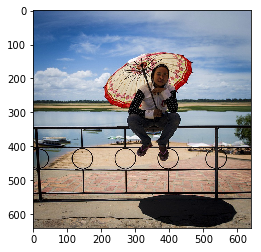

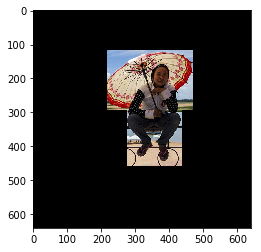

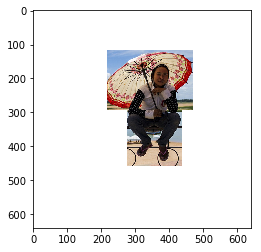

caption predicted on original image:  a woman is sitting on a bench with an umbrella
caption predicted on image with black background:  a woman walking down a street holding an umbrella
caption predicted on image with white background:  a woman holding an umbrella in the rain


In [55]:
img_original_address, text_file_address, boxed_img_address, img = show_and_save_val_example(val_img_fns, 
                                                                        val_captions, example_idx=65)

img_black, img_white = remove_background(text_file_address, img)
# cv2.imwrite('../visualization/removed_background_black.jpg', utils.image_center_crop(img))


img_original = cv2.imread(img_original_address)
plt.imshow(img_original)
plt.show()


plt.imshow(img_black)
plt.show()    

plt.imshow(img_white)
plt.show()    


caption_original = ' '.join(generate_caption(utils.crop_and_preprocess(img_original, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])

caption_black = ' '.join(generate_caption(utils.crop_and_preprocess(img_black, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])

caption_white = ' '.join(generate_caption(utils.crop_and_preprocess(img_white, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])

img_store_address = '../visualization/'
cv2.imwrite(img_store_address+'original1.jpg', utils.image_center_crop(img_original))
cv2.imwrite(img_store_address+'black1.jpg', utils.image_center_crop(img_black))
cv2.imwrite(img_store_address+'white1.jpg', utils.image_center_crop(img_white))


print('caption predicted on original image: ',caption_original)
print('caption predicted on image with black background: ', caption_black)
print('caption predicted on image with white background: ', caption_white)

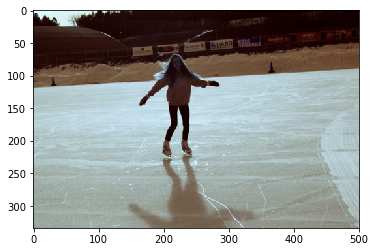

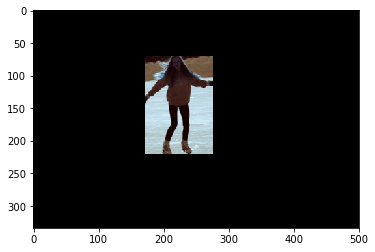

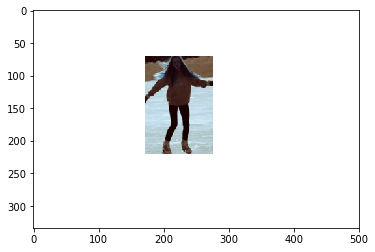

caption predicted on original image:  a man is on a surfboard in the water
caption predicted on image with black background:  a dog standing in the middle of a street
caption predicted on image with white background:  a dog is standing on a sidewalk near a parking lot


In [56]:
from copy import deepcopy
text_file_address = '../../YAD2K/images/out_selected_imgs/large.jpg.txt'
original_img_address = '../../YAD2K/images/in_selected/large.jpg'

img_original = cv2.imread(original_img_address)
temp = deepcopy(img_original)


img_black, img_white = remove_background(text_file_address, temp)

plt.imshow(img_original)
plt.show()

plt.imshow(img_black)
plt.show()

plt.imshow(img_white)
plt.show()


img_store_address = '../visualization/'
cv2.imwrite(img_store_address+'original2.jpg', utils.image_center_crop(img_original))
cv2.imwrite(img_store_address+'black2.jpg', utils.image_center_crop(img_black))
cv2.imwrite(img_store_address+'white2.jpg', utils.image_center_crop(img_white))


caption_original = ' '.join(generate_caption(utils.crop_and_preprocess(img_original, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])

caption_black = ' '.join(generate_caption(utils.crop_and_preprocess(img_black, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])

caption_white = ' '.join(generate_caption(utils.crop_and_preprocess(img_white, (IMG_SIZE, IMG_SIZE), 
                                                              final_model.preprocess_for_model))[1:-1])


print('caption predicted on original image: ',caption_original)
print('caption predicted on image with black background: ', caption_black)
print('caption predicted on image with white background: ', caption_white)


In [57]:
predicted_val_captions, predicted_val_captions_with_filenames  = run_generate_captions('val', 1000)
predicted_train_captions, predicted_train_captions_with_filenames = run_generate_captions('train', 1000)
utils.save_pickle(predicted_val_captions, "../data/coco/extracted/predicted_val_captions_{}_RNN_{}_layers_{}.pickle".format(action, RNN_TYPE, NUM_LAYERS))
utils.save_pickle(predicted_train_captions, "../data/coco/extracted/predicted_train_captions_{}_RNN_{}_layers_{}.pickle".format(action, RNN_TYPE, NUM_LAYERS))

predicting the captions for val dataset ...


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


predicting the captions for train dataset ...


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


In [58]:
def tokenize_captions(captions):
    from tokenize import tokenize
    tokenized_captions = []
    for exm in range(len(captions)):
        tokenized_example =[]
        for num_caps in range(len(captions[exm])):
            tokenized_example.append(captions[exm][num_caps].split())
        tokenized_captions.append(tokenized_example)
    return tokenized_captions

In [59]:
predicted_val_captions = utils.read_pickle(
    "../data/coco/extracted/predicted_val_captions_{}_RNN_{}_layers_{}.pickle".format(action, RNN_TYPE, NUM_LAYERS))
predicted_train_captions = utils.read_pickle(
    "../data/coco/extracted/predicted_train_captions_{}_RNN_{}_layers_{}.pickle".format(action, RNN_TYPE, NUM_LAYERS))
# predicted_val_captions = utils.read_pickle(
#     "../data/coco/extracted/predicted_val_captions_{}.pickle".format(action))
# predicted_train_captions = utils.read_pickle(
#     "../data/coco/extracted/predicted_train_captions_{}.pickle".format(action))

# pred_val_caps_token = tokenize_captions(predicted_val_captions)
# pred_train_caps_token = tokenize_captions(predicted_train_captions)

ref_val_cap_token = tokenize_captions(val_captions)
ref_train_cap_token = tokenize_captions(train_captions)

In [60]:
f = open("../../caption-eval/data/predicted_val_captions_with_filenames_{}_RNN_{}_layers_{}.txt".format(action, RNN_TYPE, NUM_LAYERS),'w')
for caption in predicted_val_captions_with_filenames:
    f.write(caption + '\n')
f.close()

f = open("../../caption-eval/data/predicted_train_captions_with_filenames_{}_RNN_{}_layers_{}.txt".format(action, RNN_TYPE, NUM_LAYERS),'w')
for caption in predicted_train_captions_with_filenames:
    f.write(caption + '\n')
f.close()
set_trace()

--Call--
> /home/farzan15/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/displayhook.py(247)__call__()
-> def __call__(self, result=None):
(Pdb) exit


BdbQuit: 

In [ ]:
# f = open("../../caption-eval/data/val_captions_with_filenames.txt",'w')
# for idx, caption_pack in enumerate(val_captions[:1000]):
#     filename = str(int(val_img_fns[idx].replace('COCO_val2014_','').replace('.jpg','')))
#     for caption in caption_pack:
#         f.write(filename + '    ' + caption + '\n')
# f.close()

# f = open("../../caption-eval/data/train_captions_with_filenames.txt",'w')
# for idx, caption_pack in enumerate(train_captions[:1000]):
#     filename = str(int(train_img_fns[idx].replace('COCO_train2014_','').replace('.jpg','')))
#     for caption in caption_pack:
#         f.write(filename + '    ' + caption + '\n')
# f.close()

In [ ]:
import nltk
def corpus_bleu_score(references, hypotheses, costume_weights=(0.25, 0.25, 0.25, 0.25)):
    return nltk.translate.bleu_score.corpus_bleu(references, hypotheses, weights=costume_weights)
def sentence_bleu_score(references, hypotheses):
    return nltk.translate.bleu_score.sentence_bleu(references, hypotheses, weights=costume_weights)

In [ ]:
val_blue_score_4 = corpus_bleu_score(ref_val_cap_token[:1000] ,predicted_val_captions)
train_blue_score_4 = corpus_bleu_score(ref_train_cap_token[:1000],predicted_train_captions)
val_blue_score_1 = corpus_bleu_score(ref_val_cap_token[:1000] ,predicted_val_captions, costume_weights=(1,0,0,0))
train_blue_score_1 = corpus_bleu_score(ref_train_cap_token[:1000],predicted_train_captions, costume_weights=(1,0,0,0))
print ('val blue score_4: {}'.format(val_blue_score_4))
print ('train blue score_4: {}'.format(train_blue_score_4))
print ('val blue score_1: {}'.format(val_blue_score_1))
print ('train blue score_1: {}'.format(train_blue_score_1))

In [ ]:
# this is an actual prediction loop
def generate_next_word_probs(image, caption, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})

    for index, word in enumerate(caption):
        if index < len(caption)-1:
            _ = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[index]]})[0]
        elif index == len(caption) - 1:
            next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[index]]})[0]
        
            next_word_probs = next_word_probs.ravel()

            # apply temperature
            next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

#             if sample:
#                 next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
#             else:
#                 next_word = np.argmax(next_word_probs)

#             caption.append(next_word)
#             if next_word == vocab[END]:
#                 break

    return next_word_probs


def apply_model_to_image_raw_bytes_return_next_word_probs(raw, par_caption):
    img = utils.decode_image_from_buf(raw)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    return generate_next_word_probs(img, par_caption)


# def run_beam_search(dataset):
#     print('predicting the captions for {} dataset ...'.format(dataset))
#     predicted_captions = []
#     if dataset == 'val':
#         img_fns = val_img_fns
#     if dataset == 'train':
#         img_fns = train_img_fns
        
#     for img_idx in tqdm(range(1)):
#         predict_single_val_captions(dataset,val_img_fns, example_idx=img_idx)
#     return predicted_captions

In [ ]:
def beam_search_predictions(dataset, beam_size=3, max_len=20, number_examples=1000):
    """
    input:
        dataset is either 'val' or 'train'
    """
    if dataset == 'val':
        zf = zipfile.ZipFile("../data/coco/val2014.zip")
        img_fns = val_img_fns
    if dataset == 'train':
        zf = zipfile.ZipFile("../data/coco/train2014.zip")
        img_fns = train_img_fns
    all_files = set(img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))

    captions_beam = []
    best_captions_beam = []
    for example_idx in tqdm(range(number_examples)):

        example = found_files[example_idx]
        image = zf.read(example)

        start = [vocab[START]]

        # start_word[0][0] = index of the starting word
        # start_word[0][1] = probability of the word predicted
        start_word = [[start, 0.0]]

        while len(start_word[0][0]) < max_len:
            temp = []
            for s in start_word:
                par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
                preds = apply_model_to_image_raw_bytes_return_next_word_probs(image, s[0])
                # set_trace()
                # Getting the top <beam_size>(n) predictions
                word_preds = np.argsort(preds)[-beam_size:]

                # creating a new list so as to put them via the model again
                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += preds[w]
                    temp.append([next_cap, prob])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        all_final_words = [case[0] for case in start_word] 
    #     start_word = start_word[-1][0]

        intermediate_captions = [[vocab_inverse[i] for i in one_caption] 
                                                  for one_caption in all_final_words]

        final_captions = []

        for one_caption in intermediate_captions:
            temp = []
            for i in one_caption:

                if i != END:
                    temp.append(i)
                else:
                    break
            final_captions.append(temp)

        final_captions = [[' '.join(final_caption[1:])] for final_caption in final_captions]
        captions_beam.append(final_captions)
#         set_trace()
        best_captions_beam.append(final_captions[-1])
    return captions_beam, best_captions_beam

In [ ]:
pred_val_beam_caps, pred_val_beam_best_caps = beam_search_predictions('val', beam_size=3, 
                                                                      max_len=20, number_examples=100)
# pred_train_beam_caps, pred_train_beam_best_caps = beam_search_predictions('train', beam_size=3, max_len=20, number_examples=10)


In [ ]:
def tokenize_beam_captions(captions):
    from tokenize import tokenize
    tokenized_captions = []
    for exm in range(len(captions)):
        tokenized_captions.append(captions[exm][0].split())
    return tokenized_captions

In [ ]:

utils.save_pickle(pred_val_beam_caps, "../data/coco/extracted/pred_val_beam_caps_{}_RNN_{}.pickle".format(action, RNN_TYPE))
utils.save_pickle(pred_val_beam_best_caps, "../data/coco/extracted/pred_val_beam_best_caps_{}_RNN_{}.pickle".format(action, RNN_TYPE))
# utils.save_pickle(pred_train_beam_caps, "../data/coco/extracted/pred_train_beam_caps_{}.pickle".format(action))
# utils.save_pickle(pred_train_beam_best_caps, "../data/coco/extracted/pred_train_beam_best_caps_{}.pickle".format(action))

# pred_val_beam_best_caps_tok = tokenize_beam_captions(pred_val_beam_best_caps)
pred_val_beam_best_caps_tok = tokenize_beam_captions(pred_val_beam_best_caps)
# pred_train_beam_best_caps_tok = tokenize_beam_captions(pred_train_beam_best_caps)


In [ ]:
beam_val_blue_score_4 = corpus_bleu_score(ref_val_cap_token[:100], pred_val_beam_best_caps_tok)
beam_val_blue_score_1 = corpus_bleu_score(ref_val_cap_token[:100], pred_val_beam_best_caps_tok, costume_weights=(1,0,0,0))
# beam_train_blue_score_4 = corpus_bleu_score(ref_train_cap_token[:100], pred_train_beam_best_caps_tok)
# beam_train_blue_score_1 = corpus_bleu_score(ref_train_cap_token[:100], pred_train_beam_best_caps_tok, costume_weights=(1,0,0,0))
print ('beam val blue score_4: {}'.format(beam_val_blue_score_4))
print ('beam val blue score_1: {}'.format(beam_val_blue_score_1))
# print ('beam train blue score_4: {}'.format(beam_train_blue_score_4))
# print ('beam train blue score_1: {}'.format(beam_train_blue_score_1))